In [38]:
# Loading and parsing data

# PLOT - parse data + std-dev
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from scipy import stats

plt.style.use('seaborn')
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style("whitegrid")

data_path = os.path.join(os.path.pardir, 'state')
sizes = [10, 1024, 102400, 1048576, 5242880]

# read praas data
#for size in sizes:
data = pd.read_csv(os.path.join(data_path, 'state_s3_fargate.csv'), sep=',| ')
#print(data)
#data.set_index('id', drop=True, inplace=True)
data['time'] /= 1000.0 * 1000.0
data['type'] = 's3'
data.drop(['repetition'], axis=1, inplace=True)

praas_data = pd.read_csv(os.path.join(data_path, 'state_put_fargate.csv'), sep=',| ')
#print(data)
#data.set_index('id', drop=True, inplace=True)
praas_data['time'] /= 1000.0 * 1000.0
praas_data['type'] = 'put_get'
praas_data.drop(['repetition'], axis=1, inplace=True)

redis_data = pd.read_csv(os.path.join(data_path, 'redis_fargate.csv'), sep=',| ')
#print(data)
#data.set_index('id', drop=True, inplace=True)
redis_data['time'] /= 1000.0 * 1000.0
redis_data['type'] = 'redis'
redis_data.drop(['repetition'], axis=1, inplace=True)

                   
data_praas = pd.concat([redis_data, data], axis=0)
print(data_praas)

        size  msg          time   type
0         10    1      1.635665  redis
1         10    1      1.541141  redis
2         10    1      1.566500  redis
3         10    1      1.507139  redis
4         10    1      1.503806  redis
...      ...  ...           ...    ...
2495  100000  100  12687.727705     s3
2496  100000  100  12644.822368     s3
2497  100000  100  11971.531553     s3
2498  100000  100  12301.432043     s3
2499  100000  100  12662.402275     s3

[5000 rows x 4 columns]


/tmp/ipykernel_1401544/3225750346.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/tmp/ipykernel_1401544/3225750346.py:21: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(os.path.join(data_path, 'state_s3_fargate.csv'), sep=',| ')
/tmp/ipykernel_1401544/3225750346.py:28: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  praas_data = 

In [46]:
#print(data)
result_s3 = data.groupby(['size', 'msg']).median().unstack()
result_redis = redis_data.groupby(['size', 'msg']).median().unstack()
result_praas = praas_data.groupby(['size', 'msg']).median().unstack()
print(result_praas)
print(result_redis)

s3_diff = result_s3/result_praas
redis_diff = result_redis/result_praas

s3_diff.sort_index(level=0, ascending=False, inplace=True)
redis_diff.sort_index(level=0, ascending=False, inplace=True)
print(s3_diff)
print(redis_diff)
#pivot(index='size', columns='msg', values='time')

            time                                                
msg          1          10          25          50           100
size                                                            
10      0.739750   7.493519   18.754019   38.104274    77.166132
100     0.752682   7.602208   18.937491   38.242783    76.632941
1000    0.798943   8.238308   20.972898   41.123804    83.973377
10000   1.164725  11.491499   29.460378   59.250489   118.686684
100000  8.861498  88.660267  268.796920  537.577951  1075.148297
             time                                                 
msg           1           10          25          50           100
size                                                              
10       1.444962   15.424787   39.010581   75.364544   142.897389
100      1.417730   14.226885   35.729883   73.160089   149.597400
1000     1.614360   16.421025   39.814302   80.673525   162.672429
10000    2.481297   24.639859   61.313928  122.866335   245.981486
100000  10.

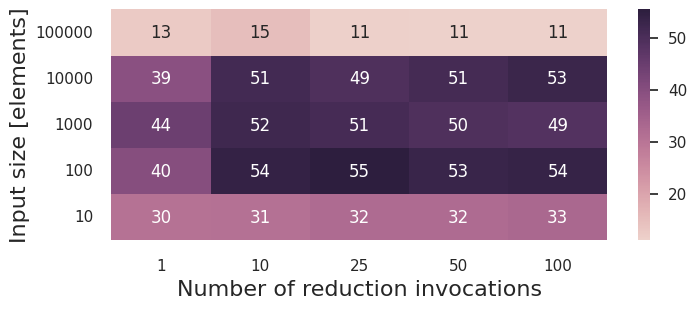

In [51]:

sns.set(rc={'figure.figsize':(8,3)})
ax = plt.gca()


sns.heatmap(s3_diff, annot=True, cmap=sns.cubehelix_palette(as_cmap=True))


ax.set_xticklabels(['1', '10', '25', '50', '100'])
ax.set_xlabel('Number of reduction invocations',fontsize=16)
ax.set_ylabel('Input size [elements]',fontsize=16)
ax.set_title("")


ax.figure.savefig("state_s3.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)

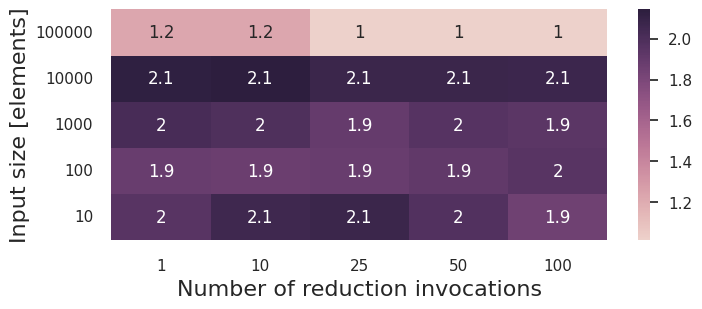

In [52]:

sns.set(rc={'figure.figsize':(8,3)})
ax = plt.gca()

sns.heatmap(redis_diff, annot=True, cmap=sns.cubehelix_palette(as_cmap=True))


ax.set_xticklabels(['1', '10', '25', '50', '100'])
ax.set_xlabel('Number of reduction invocations',fontsize=16)
ax.set_ylabel('Input size [elements]',fontsize=16)
ax.set_title("")


ax.figure.savefig("state_redis.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)

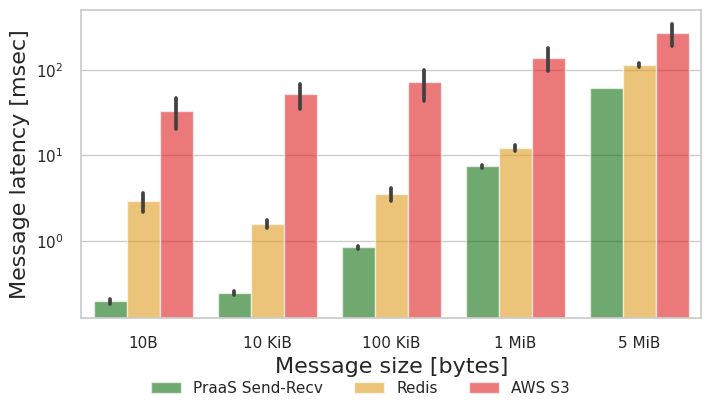

In [21]:

ax = plt.gca()


color = ['green','orange','red','blue','limegreen','darkgreen','royalblue','navy']


sns.barplot(
    data=data_praas,
    x="size", y="time", hue="type", hue_order=["put_get", "redis", "s3"],
    errorbar="sd", alpha=.6,#, height=6,
    estimator=p50_estimator, palette=color,
    ax=ax
)

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",color='black',shrinkA=0,shrinkB=0)

#plt.annotate("", ha='left',xy=(0.1,2), xytext=(0.3,25), arrowprops=prop)
#ax.arrow(0.3, 25, -0.2, -23, head_width=0.1, head_length=0.4, fc='k', ec='k')
#plt.annotate("94% Reduction", ha='left',xy=(0,25), xytext=(0,25))
#plt.annotate("", ha='left',xy=(1.1,2), xytext=(1.3,25), arrowprops=prop)
#ax.arrow(0.3, 25, -0.2, -23, head_width=0.1, head_length=0.4, fc='k', ec='k')
#plt.annotate("93% Reduction", ha='left',xy=(1,25), xytext=(1,25))


#plt.annotate("94%, 93%, 91%, 83% and 69% latency reduction against Lambda", ha='left',xy=(-0.5,150), xytext=(-0.5,150))
#plt.annotate("", ha='left',xy=(1.1,2), xytext=(1.1,100), arrowprops=prop)
#plt.annotate("", ha='left',xy=(0.1,2), xytext=(0.1,100), arrowprops=prop)
#plt.annotate("", ha='left',xy=(2.1,2), xytext=(2.1,100), arrowprops=prop)
#plt.annotate("", ha='left',xy=(3.1,2), xytext=(3.1,100), arrowprops=prop)
    

#ax.despine(left=True)
ax.set_yscale("log")
ax.set_xlabel('Message size [bytes]',fontsize=16)
ax.set_ylabel('Message latency [msec]',fontsize=16)
ax.set_title("")

ax.set_xticklabels(['10B', '10 KiB', '100 KiB', '1 MiB', '5 MiB'])

import copy
import matplotlib.patches as mpatches

from matplotlib.lines import Line2D
#p = copy.copy(ax.get_legend_handles_labels()[0][0])
#print(dir(p.patches[0]))
#print(p.patches[1].set_color('black'))
#print(p.patches[2])
#print(p.patches[3])
#print(p.patches[4])
#print(ax.get_legend_handles_labels()[0][0].patches
p = Line2D([0], [0], color='black', ls='--',lw=2, label='black')
red_patch = mpatches.Patch(color='black', label='The red data')
ax.legend(loc='center', bbox_to_anchor=(0.45, -0.23),
    handles=ax.get_legend_handles_labels()[0],
    labels=['PraaS Send-Recv', 'Redis', 'AWS S3'],
    ncols=4        
)

import scienceplots

#plt.style.use(["science", "high-contrast", "ieee"])
ax.figure.savefig("ipc_latency.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)

In [24]:
for size in [10, 1024, 102400, 1048576, 5242880]:
    #print('Warm Latency', data_praas.loc[(data_praas['type'] == 'praas_local') & (data_praas['size'] == size)]['time'].median())
    #print('Hot Latency', data_praas.loc[(data_praas['type'] == 'praas_remote') & (data_praas['size'] == size)]['time'].median())
    #print('AWS', data_praas.loc[(data_praas['type'] == 'aws') & (data_praas['size'] == size)]['time'].median())
    print(size, 'put_get', 1-(data_praas.loc[(data_praas['type'] == 'put_get') & (data_praas['size'] == size)]['time'].median()/data_praas.loc[(data_praas['type'] == 's3') & (data_praas['size'] == size)]['time'].median()))
    
#print('')


for size in [10, 1024, 102400, 1048576, 5242880]:
    #print('Warm Latency', data_praas.loc[(data_praas['type'] == 'praas_local') & (data_praas['size'] == size)]['time'].median())
    #print('Hot Latency', data_praas.loc[(data_praas['type'] == 'praas_remote') & (data_praas['size'] == size)]['time'].median())
    #print('AWS', data_praas.loc[(data_praas['type'] == 'aws') & (data_praas['size'] == size)]['time'].median())
    print(size, 'redis', 1-(data_praas.loc[(data_praas['type'] == 'put_get') & (data_praas['size'] == size)]['time'].median()/data_praas.loc[(data_praas['type'] == 'redis') & (data_praas['size'] == size)]['time'].median()))

10 put_get 0.9941210247532077
1024 put_get 0.9953150922528842
102400 put_get 0.9883475153114367
1048576 put_get 0.9469814138190564
5242880 put_get 0.7715559761478028
10 redis 0.9323715011055067
1024 redis 0.8446152157701092
102400 redis 0.7629107118888834
1048576 redis 0.39318250598236704
5242880 redis 0.46116738937028345


In [5]:

data_docker = pd.read_csv(os.path.join(data_path, 'praas_local', 'dataplane_sizes_fargate_local_docker.csv'))
#data.set_index('id', drop=True, inplace=True)
data_docker['time'] /= 1000.0 * 1000.0
data_docker['type'] = 'praas_local'
data_docker.drop(['repetition'], axis=1, inplace=True)

data_cpu = pd.read_csv(os.path.join(data_path, 'praas_local', 'dataplane_sizes_fargate_local_1cpu.csv'))
#data.set_index('id', drop=True, inplace=True)
data_cpu['time'] /= 1000.0 * 1000.0
data_cpu['type'] = 'praas_local'
data_cpu.drop(['repetition'], axis=1, inplace=True)

for size in [10, 1024, 102400, 1048576, 5242880]:
    #print('Warm Latency', data_praas.loc[(data_praas['type'] == 'praas_local') & (data_praas['size'] == size)]['time'].median())
    #print('Hot Latency', data_praas.loc[(data_praas['type'] == 'praas_remote') & (data_praas['size'] == size)]['time'].median())
    #print('AWS', data_praas.loc[(data_praas['type'] == 'aws') & (data_praas['size'] == size)]['time'].median())
    
    local = data_praas.loc[(data_praas['type'] == 'praas_local') & (data_praas['size'] == size)]['time'].median()
    cpu = data_cpu.loc[(data_cpu['type'] == 'praas_local') & (data_cpu['size'] == size)]['time'].median()
    docker = data_docker.loc[(data_docker['type'] == 'praas_local') & (data_docker['size'] == size)]['time'].median()
    print(docker, local)
    print('1CPU', 1 - cpu/local)
    print('Docker', local/docker)
    

0.0637885 0.07331950000000001
1CPU 0.06796282025927636
Docker 1.1494156470210148
0.0659865 0.0740715
1CPU 0.07297003570874083
Docker 1.1225250619444886
0.294107 0.34975900000000004
1CPU 0.13810509522271064
Docker 1.1892236498961264
3.2509865 4.19101
1CPU 0.11862104838690435
Docker 1.289150231783491
17.2484045 21.327219499999998
1CPU 0.07364070595325367
Docker 1.2364749156943762
